In [2]:
# 사용 라이브러리
import requests
import pandas as pd
import json
from pandas.io.json import json_normalize
from ast import literal_eval
import urllib.parse as urlparse
import time

import warnings
warnings.filterwarnings('ignore')

In [3]:
# API 요청 파라미터 입력
def get_data():
    from ast import literal_eval
    URL = str(input("URL 주소를 입력하시오: "))
    API_KEY = str(input("인증키를 입력하시오: "))
    OPERATION = str(input("상세기능명을 입력하시오(영문): "))
    NUMOFROWS = str(input("한 페이지에 노출할 결과 수를 입력하시오: "))
    PAGENO = str(input("페이지 번호를 입력하시오: "))
    DATATYPE = "XML"
    PARAMS_KEY = list(input("필수 파라미터명 공백으로 구분하여 입력하시오: ").split())
    PARAMS_VALUE = list(input("필수 파라미터값 공백으로 구분하여 입력하시오: ").split())
    PARAMS_STR = str(dict(zip(PARAMS_KEY, PARAMS_VALUE)))
    PARAMS = literal_eval(PARAMS_STR)

# CODE 값은 필수적으로 입력해야한다.
# API 파라미터에 코드와 관련된 파라미터가 없을 시, 그 외 파라미터 중 하나를 입력한다.
    CODENAME = str(input('지점번호, 지역코드와 관련된 항목명을 입력하시오: '))
    CODE = list(input('지점번호, 지역코드를 입력하시오: ').split())

    request_query = get_request_query(URL, OPERATION, PAGENO, NUMOFROWS, DATATYPE, PARAMS, CODENAME, CODE, API_KEY)
    print(request_query)
    return request_query

In [4]:
# API URL 요청
# 호출한 URL을 조합하여 링크를 생성한다.
def get_request_query(url, operation, pageno, numofrows, datatype, params, codename, code, serviceKey):
    import urllib.parse as urlparse
    params = urlparse.urlencode(params)
    request_query = []
    for i in range(len(code)):
        f_url = url + "/" + operation + "?" + "pageNo" + "=" + pageno + "&" + "numOfRows" + "=" + numofrows + "&" + "dataType" + "=" + datatype + "&" + params + "&" + codename + "=" + \
                code[i] + "&" + "serviceKey" + "=" + serviceKey
        f_url.encode('utf-8')
        request_query.append(f_url)

    return request_query

In [5]:
# URL GET
# 지역 코드를 여러개 입력한 경우 각각 url을 받아온다.
def loop_request_query(request_query):
    for query in request_query:
        response = requests.get(url=query)
    return response

### JSON으로 데이터 받을 시 해당 오류 발생하여,
### XML로 데이터를 받은 뒤 JSON으로 변환 작업 수행
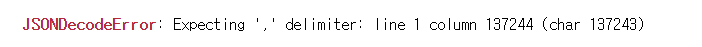

In [6]:
# XML을 JSON으로 변환
def json_response(response):
    import xmltodict
    json_ = response.text
    #print(json_)
    jsonString = json.dumps(xmltodict.parse(json_), indent=4)
    json_object = json.loads(jsonString)
    #print(json_object)
    return json_object

### 데이터 요청시 제공되는 API depth의 차이가 존재.
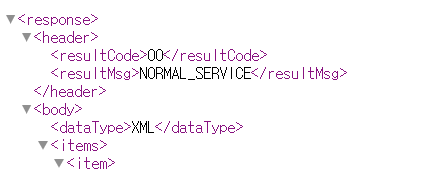

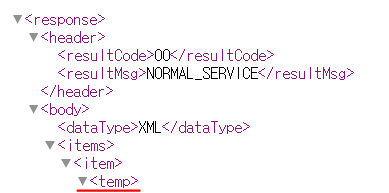

In [10]:
# 위의 문제를 해결하기 위해서, 다양한 경우의 수를 만들어 놓았다.
# 현재 정의해놓은 깊이의 개수보다 더 다양한 경우,
# 사용자의 input을 통해 받는 방법이 있다.
# 키, 값 형태도 데이터를 추출한 뒤 테이블 생성
def find_json_error(json_object):

    key_type = type(json_object['response']['body']['items']['item'])
    if key_type == list:
        df = json_normalize(json_object['response']['body']['items']['item'])

    else:
        try:
            key_ = json_object['response']['body']['items']['item']['year']['info'][0].keys()
            df = json_normalize(json_object['response']['body']['items']['item']['year']['info'])            
     
        except:
            key_ = json_object['response']['body']['items']['item']['temp']['info'][0].keys()
            df = json_normalize(json_object['response']['body']['items']['item']['temp']['info'])             
        
    key_ = list(key_)
    df.columns = [key_]
    return df

In [11]:
# 실행 및 테이블 저장
def main():
    request_query = get_data()

    response = loop_request_query(request_query)

    json_object = json_response(response)

# 데이터프레임 csv 파일로 저장
    df = find_json_error(json_object)
    df_name = input("파일명을 입력하시오: ")
    df.to_csv('data/' + df_name + '.csv', index=False, encoding='cp949')
    df_describe = df.describe()
    df_describe.to_csv('data/' + df_name + '_describe.csv', index=True, encoding='cp949')

In [12]:
# 지상기상연보
main()

URL 주소를 입력하시오: http://apis.data.go.kr/1360000/SfcYearlyInfoService
인증키를 입력하시오: 0VPHiLnleAB93gjILfRfKRQcBuFBbb9XArHRML7HRiBSrkUV4GZxTwOsm%2Fm%2FloyDIFYPsLSoNQFg2j%2FAfxNfnQ%3D%3D
상세기능명을 입력하시오(영문): getYearSumry
한 페이지에 노출할 결과 수를 입력하시오: 999
페이지 번호를 입력하시오: 1
필수 파라미터명 공백으로 구분하여 입력하시오: 
필수 파라미터값 공백으로 구분하여 입력하시오: 
지점번호, 지역코드와 관련된 항목명을 입력하시오: year
지점번호, 지역코드를 입력하시오: 2018
['http://apis.data.go.kr/1360000/SfcYearlyInfoService/getYearSumry?pageNo=1&numOfRows=999&dataType=XML&&year=2018&serviceKey=0VPHiLnleAB93gjILfRfKRQcBuFBbb9XArHRML7HRiBSrkUV4GZxTwOsm%2Fm%2FloyDIFYPsLSoNQFg2j%2FAfxNfnQ%3D%3D']
파일명을 입력하시오: 555


In [15]:
# 방재기상연보
main()

URL 주소를 입력하시오: http://apis.data.go.kr/1360000/AwsYearlyInfoService
인증키를 입력하시오: 0VPHiLnleAB93gjILfRfKRQcBuFBbb9XArHRML7HRiBSrkUV4GZxTwOsm%2Fm%2FloyDIFYPsLSoNQFg2j%2FAfxNfnQ%3D%3D
상세기능명을 입력하시오(영문): getYearSumry
한 페이지에 노출할 결과 수를 입력하시오: 999
페이지 번호를 입력하시오: 1
필수 파라미터명 공백으로 구분하여 입력하시오: year
필수 파라미터값 공백으로 구분하여 입력하시오: 2019
지점번호, 지역코드와 관련된 항목명을 입력하시오: month
지점번호, 지역코드를 입력하시오: 01
['http://apis.data.go.kr/1360000/AwsYearlyInfoService/getYearSumry?pageNo=1&numOfRows=999&dataType=XML&year=2019&month=01&serviceKey=0VPHiLnleAB93gjILfRfKRQcBuFBbb9XArHRML7HRiBSrkUV4GZxTwOsm%2Fm%2FloyDIFYPsLSoNQFg2j%2FAfxNfnQ%3D%3D']
파일명을 입력하시오: t1
